# Data Preparation

In [1]:
import warnings
import glob
import itertools
import numpy as np
import math
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy import stats
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('nhsd.csv')

In [3]:
data

,Department Family,Entity,Invoice Date,Consolidated Expense Type,Expense area,Supplier,Purchase Invoice Number,Invoice Value,Description
0,Department of Health,NHS Digital,3/7/2017,Managed Service,Provider Support and Integration,BT GLOBAL SERVICES,436370,"6,807,712.85",Managed Service
1,Department of Health,NHS Digital,1/20/2017,Managed Service,Provider Support & Integration,BT GLOBAL SERVICES,432441,"6,772,892.05",Managed Service
2,Department of Health,NHS Digital,2/16/2017,Managed Service,Provider Support & Integration,BT GLOBAL SERVICES,433587,"6,479,154.77",Managed Service
3,Department of Health,NHS Digital,3/7/2017,Managed Service,Provider Support and Integration,BT GLOBAL SERVICES,436212,"6,457,105.37",Managed Service
4,Department of Health,NHS Digital,12/22/2016,Managed Service,Provider Support & Integration,BT GLOBAL SERVICES,430649,"6,379,986.78",Managed Service
...,...,...,...,...,...,...,...,...,...
5597,Department of Health and Social Care,NHS Digital,5/31/2020,Workpackage,Assurance and Risk Management,VALTECH LTD,UKSI9979,"27,696.00",Workpackages
5598,Department of Health and Social Care,NHS Digital,8/28/2020,Legal Fees and Services,Corporate Services,WOMBLE BOND DICKINSON (UK) LLP,3502379,"25,401.24",Legal Fees
5599,Department of Health and Social Care,NHS Digital,3/31/2020,Managed Service,Platforms,WOODWARD ASSOCIATES UK LTD,4614,"33,750.00",Fully Managed and Other Outsourced IT Services
5600,Department of Health and Social Care,NHS Digital,6/30/2020,Managed Service,Platforms,WOODWARD ASSOCIATES UK LTD,4666,"33,750.00",Fully Managed and Other Outsourced IT Services


In [5]:
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'], dayfirst=True)

In [7]:
data['Invoice Value'] = data['Invoice Value'].str.replace(',','')

In [8]:
data['Invoice Value'] = pd.to_numeric(data['Invoice Value'])

In [9]:
data

,Department Family,Entity,Invoice Date,Consolidated Expense Type,Expense area,Supplier,Purchase Invoice Number,Invoice Value,Description
0,Department of Health,NHS Digital,2017-07-03,Managed Service,Provider Support and Integration,BT GLOBAL SERVICES,436370,6807712.85,Managed Service
1,Department of Health,NHS Digital,2017-01-20,Managed Service,Provider Support & Integration,BT GLOBAL SERVICES,432441,6772892.05,Managed Service
2,Department of Health,NHS Digital,2017-02-16,Managed Service,Provider Support & Integration,BT GLOBAL SERVICES,433587,6479154.77,Managed Service
3,Department of Health,NHS Digital,2017-07-03,Managed Service,Provider Support and Integration,BT GLOBAL SERVICES,436212,6457105.37,Managed Service
4,Department of Health,NHS Digital,2016-12-22,Managed Service,Provider Support & Integration,BT GLOBAL SERVICES,430649,6379986.78,Managed Service
...,...,...,...,...,...,...,...,...,...
5597,Department of Health and Social Care,NHS Digital,2020-05-31,Workpackage,Assurance and Risk Management,VALTECH LTD,UKSI9979,27696.00,Workpackages
5598,Department of Health and Social Care,NHS Digital,2020-08-28,Legal Fees and Services,Corporate Services,WOMBLE BOND DICKINSON (UK) LLP,3502379,25401.24,Legal Fees
5599,Department of Health and Social Care,NHS Digital,2020-03-31,Managed Service,Platforms,WOODWARD ASSOCIATES UK LTD,4614,33750.00,Fully Managed and Other Outsourced IT Services
5600,Department of Health and Social Care,NHS Digital,2020-06-30,Managed Service,Platforms,WOODWARD ASSOCIATES UK LTD,4666,33750.00,Fully Managed and Other Outsourced IT Services


In [11]:
data['Expense area'] = data['Expense area'].replace({'Platforms': 'Platforms and Infrastructure',
                                                    'various': 'Various', 'Various ': 'Various', 'Workforce ': 'Various', 
                                                     'Product Development ': 'Product Development',
                                                     'Provider Support & Integration ': 'Product Development',
                                                     'Provider Support and Integration ': 'Product Development',
                                                    'Information and Analytics ': 'Data, Insights and Statistics',
                                                    'Data Services': 'Data, Insights and Statistics',
                                                    'Corporate Services': 'Finance and Corporate Services',
                                                    'Finance and Corporate Services ': 'Finance and Corporate Services',
                                                    'Platforms and Infraestructure': 'Platforms and Infrastructure',
                                                    'Strategy,Policy and Governance': 'Strategy, Policy and Governance',
                                                    'Information and Analytics': 'Data, Insights and Statistics',
                                                    'Operations and Assurance Services': 'Assurance and Risk Management',
                                                    'Live Services (incl. Cyber Security)': 'IT Operations',
                                                    'Operations and Assurance Services ': 'Assurance and Risk Management',
                                                    'Health Digital Services ': 'Product Development',
                                                    'Workforce': 'Various',
                                                    'Digital Transformation': 'Platforms and Infrastructure',
                                                    'Provider Support and Integration': 'Product Development'})
data['Expense area'].value_counts(normalize=True)


Platforms and Infrastructure       0.284006
Product Development                0.246698
IT Operations                      0.126026
Finance and Corporate Services     0.094252
Various                            0.089611
Data, Insights and Statistics      0.078900
Assurance and Risk Management      0.060871
Strategy, Policy and Governance    0.019636
Name: Expense area, dtype: float64

In [12]:
area=["Platforms and Infrastructure","Product Development","IT Operations","Finance and Corporate Services","Various","Data, Insights and Statistics","Assurance and Risk Management","Strategy, Policy and Governance"]

## Modelling

In [13]:
def ts(name,data):
    prde = data.loc[data['Expense area'] == name].reset_index(drop=True)
    prde = prde[['Invoice Date', 'Invoice Value']]
    prde['Invoice Date'].min(), prde['Invoice Date'].max()
    prde = prde.groupby('Invoice Date')['Invoice Value'].sum().reset_index()
    prde = prde.set_index('Invoice Date')
    y = prde['Invoice Value'].resample('MS').mean()
    y = y['2018':]
    y = y.interpolate()
    return y

In [14]:
def ts_all(name,data):
    prde = data.loc[data['Expense area'] == name].reset_index(drop=True)
    prde = prde[['Invoice Date', 'Invoice Value']]
    prde['Invoice Date'].min(), prde['Invoice Date'].max()
    prde = prde.groupby('Invoice Date')['Invoice Value'].sum().reset_index()
    prde = prde.set_index('Invoice Date')
    y = prde['Invoice Value'].resample('MS').mean()
    y = y.interpolate()
    return y

In [31]:
def prophet_model_additive(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts(name, data)[:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95, seasonality_mode = 'additive')
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods, freq='MS')
    forecast = pandi_model.predict(future)
    pandi_model.plot(forecast, uncertainty=True, xlabel = 'Invoice Date', ylabel = 'Invoice Value')
    plt.title(name)
    plt.show()
    pandi_model.plot_components(forecast)
    plt.show()
    f = forecast.tail(periods)
    return f

In [32]:
def prophet_model_multiplicative(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts(name, data)[:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95, seasonality_mode = 'multiplicative')
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods, freq='MS')
    forecast = pandi_model.predict(future)
    pandi_model.plot(forecast, uncertainty=True, xlabel = 'Invoice Date', ylabel = 'Invoice Value')
    plt.title(name)
    plt.show()
    pandi_model.plot_components(forecast)
    plt.show()
    f = forecast.tail(periods)
    return f

In [33]:
def forecast_dataframe(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts(name, data)[:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95)
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods,freq='MS')
    forecast = pandi_model.predict(future)
    return forecast

In [39]:
def residuals_additive(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts(name, data)[:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95, seasonality_mode = 'additive')
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods,freq='MS')
    forecast = pandi_model.predict(future)
    df = pd.merge(pandi, forecast, on='ds')
    residuals = df['y'] - df['yhat']
    residuals = pd.Series(residuals)/np.std(residuals)
    f = plt.figure(1)
    residuals.plot(title = name, ylabel = 'Standardized Residual', xlabel = 'Order')
    plt.axhline(y=0, color='r', linestyle='-')
    f.show()
    g = plt.figure(2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    g.show()
    h = plt.figure(3)
    plot_acf(residuals)
    h.show()
    return 

In [40]:
def residuals_multiplicative(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts(name, data)[:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95, seasonality_mode = 'multiplicative')
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods,freq='MS')
    forecast = pandi_model.predict(future)
    df = pd.merge(pandi, forecast, on='ds')
    residuals = df['y'] - df['yhat']
    residuals = pd.Series(residuals)/np.std(residuals)
    f = plt.figure(1)
    residuals.plot(title = name, ylabel = 'Standardized Residual', xlabel = 'Order')
    plt.axhline(y=0, color='r', linestyle='-')
    f.show()
    g = plt.figure(2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    g.show()
    h = plt.figure(3)
    plot_acf(residuals)
    h.show()
    return 

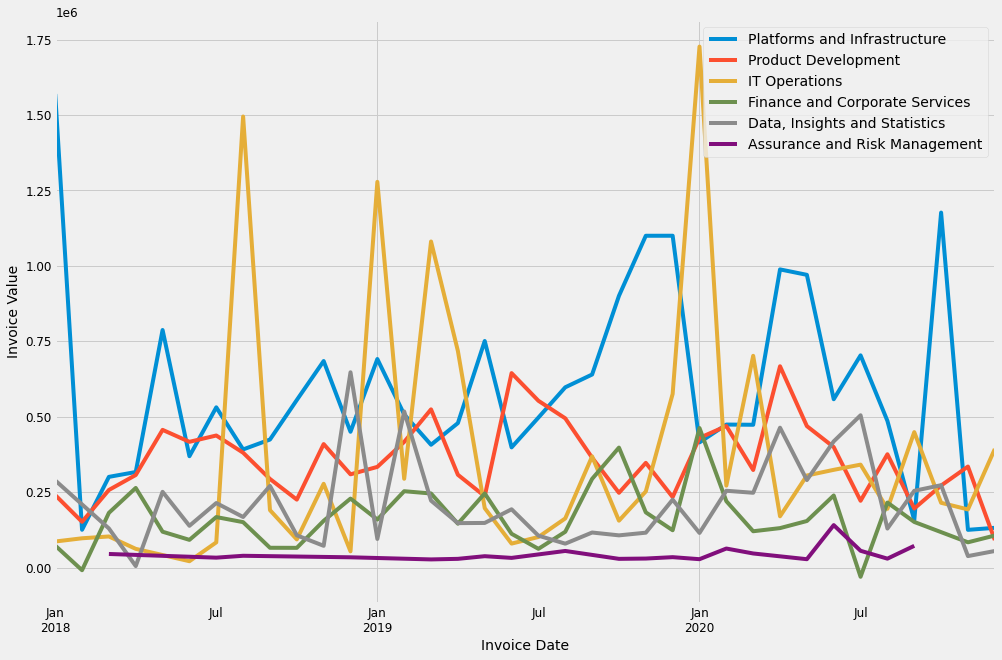

In [36]:
ts(area[0], data).plot(label = area[0], figsize = (15,10))
ts(area[1], data).plot(label = area[1])
ts(area[2], data).plot(label = area[2])
ts(area[3], data).plot(label = area[3])
ts(area[5], data).plot(label = area[5])
ts(area[6], data).plot(label = area[6])
plt.ylabel('Invoice Value')
plt.legend(loc='upper right')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


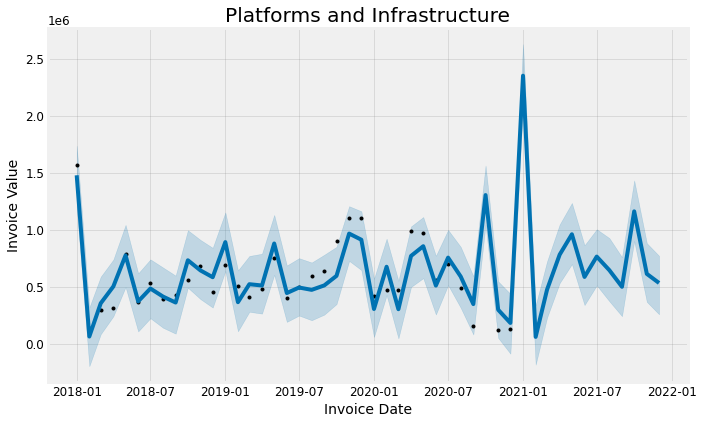

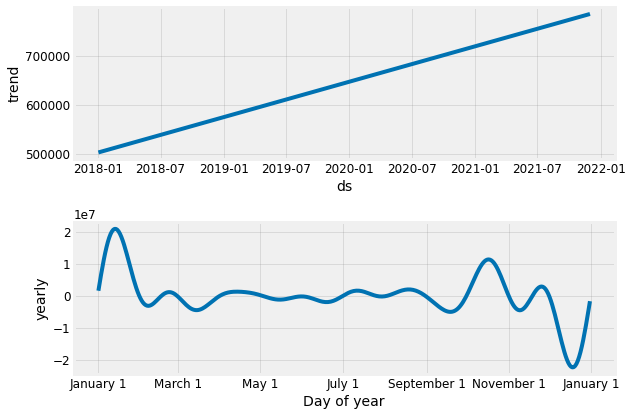

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2021-01-01,719573.163112,2.115005e+06,2.626037e+06,719572.795416,719573.570539,1.629961e+06,1.629961e+06,1.629961e+06,1.629961e+06,1.629961e+06,1.629961e+06,0.0,0.0,0.0,2.349534e+06
37,2021-02-01,725699.778545,-1.829074e+05,3.366074e+05,725698.697814,725700.861123,-6.650717e+05,-6.650717e+05,-6.650717e+05,-6.650717e+05,-6.650717e+05,-6.650717e+05,0.0,0.0,0.0,6.062805e+04
38,2021-03-01,731233.495711,2.295506e+05,7.221374e+05,731231.549699,731235.343605,-2.566896e+05,-2.566896e+05,-2.566896e+05,-2.566896e+05,-2.566896e+05,-2.566896e+05,0.0,0.0,0.0,4.745439e+05
39,2021-04-01,737360.111145,5.326617e+05,1.046272e+06,737357.165268,737362.999340,4.408127e+04,4.408127e+04,4.408127e+04,4.408127e+04,4.408127e+04,4.408127e+04,0.0,0.0,0.0,7.814414e+05
40,2021-05-01,743289.093823,6.984788e+05,1.234028e+06,743285.006296,743293.245696,2.166629e+05,2.166629e+05,2.166629e+05,2.166629e+05,2.166629e+05,2.166629e+05,0.0,0.0,0.0,9.599520e+05
41,2021-06-01,749415.709257,3.394514e+05,8.634357e+05,749410.384634,749420.885857,-1.633577e+05,-1.633577e+05,-1.633577e+05,-1.633577e+05,-1.633577e+05,-1.633577e+05,0.0,0.0,0.0,5.860580e+05
42,2021-07-01,755344.691935,5.119261e+05,1.003617e+06,755338.083635,755351.255540,8.999597e+03,8.999597e+03,8.999597e+03,8.999597e+03,8.999597e+03,8.999597e+03,0.0,0.0,0.0,7.643443e+05
43,2021-08-01,761471.307369,3.729859e+05,9.263183e+05,761463.225950,761479.342203,-1.162543e+05,-1.162543e+05,-1.162543e+05,-1.162543e+05,-1.162543e+05,-1.162543e+05,0.0,0.0,0.0,6.452170e+05
44,2021-09-01,767597.922803,2.421515e+05,7.589429e+05,767588.102668,767607.297536,-2.679327e+05,-2.679327e+05,-2.679327e+05,-2.679327e+05,-2.679327e+05,-2.679327e+05,0.0,0.0,0.0,4.996652e+05
45,2021-10-01,773526.905481,9.006346e+05,1.431683e+06,773515.356853,773537.828525,3.871606e+05,3.871606e+05,3.871606e+05,3.871606e+05,3.871606e+05,3.871606e+05,0.0,0.0,0.0,1.160687e+06


In [41]:
prophet_model_additive(1, area[0], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


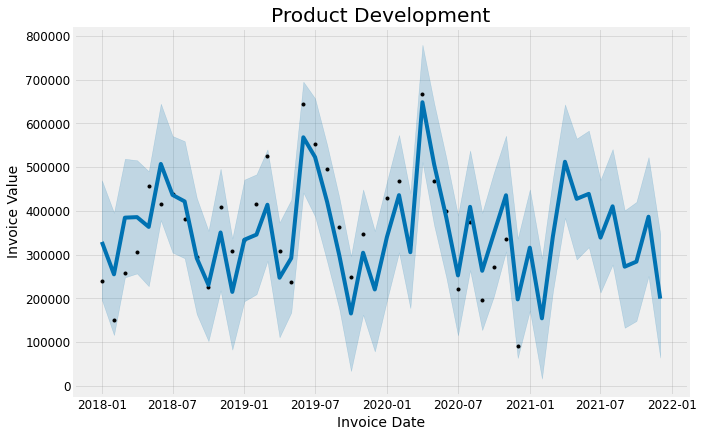

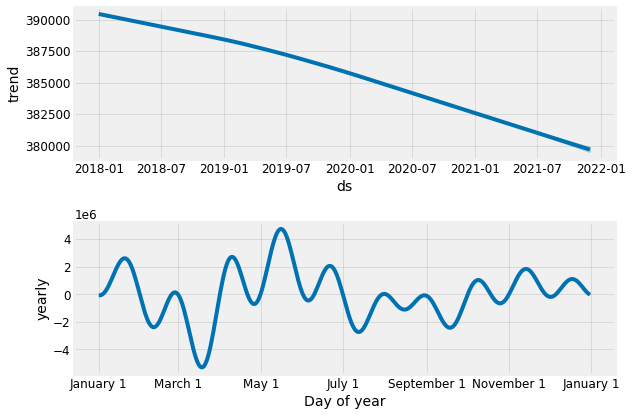

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2021-01-01,382582.121139,172063.007548,448995.233142,382576.374449,382589.611885,-66688.312156,-66688.312156,-66688.312156,-66688.312156,-66688.312156,-66688.312156,0.0,0.0,0.0,315893.808983
37,2021-02-01,382313.218466,16591.143808,291483.159474,382297.742641,382332.345174,-227908.964992,-227908.964992,-227908.964992,-227908.964992,-227908.964992,-227908.964992,0.0,0.0,0.0,154404.253474
38,2021-03-01,382070.338633,215366.294118,473025.268042,382042.176389,382102.336208,-40900.620612,-40900.620612,-40900.620612,-40900.620612,-40900.620612,-40900.620612,0.0,0.0,0.0,341169.718021
39,2021-04-01,381801.435960,384114.698150,643176.939415,381757.872961,381851.191995,130454.835063,130454.835063,130454.835063,130454.835063,130454.835063,130454.835063,0.0,0.0,0.0,512256.271023
40,2021-05-01,381541.207566,289045.794674,565177.075512,381477.809857,381609.789957,45940.791282,45940.791282,45940.791282,45940.791282,45940.791282,45940.791282,0.0,0.0,0.0,427481.998849
41,2021-06-01,381272.304893,317015.579187,583276.360559,381192.565579,381359.400929,57581.213017,57581.213017,57581.213017,57581.213017,57581.213017,57581.213017,0.0,0.0,0.0,438853.517910
42,2021-07-01,381012.076500,213335.397400,470634.874981,380909.569548,381121.274493,-42163.288431,-42163.288431,-42163.288431,-42163.288431,-42163.288431,-42163.288431,0.0,0.0,0.0,338848.788070
43,2021-08-01,380743.173827,277166.139359,541153.643417,380618.675423,380880.309460,29665.065988,29665.065988,29665.065988,29665.065988,29665.065988,29665.065988,0.0,0.0,0.0,410408.239815
44,2021-09-01,380474.271154,132826.651656,401125.733618,380333.187432,380632.467675,-108056.136030,-108056.136030,-108056.136030,-108056.136030,-108056.136030,-108056.136030,0.0,0.0,0.0,272418.135124
45,2021-10-01,380214.042761,148427.667698,420360.922522,380043.533977,380392.832546,-96296.339921,-96296.339921,-96296.339921,-96296.339921,-96296.339921,-96296.339921,0.0,0.0,0.0,283917.702840


In [43]:
prophet_model_additive(1, area[1], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


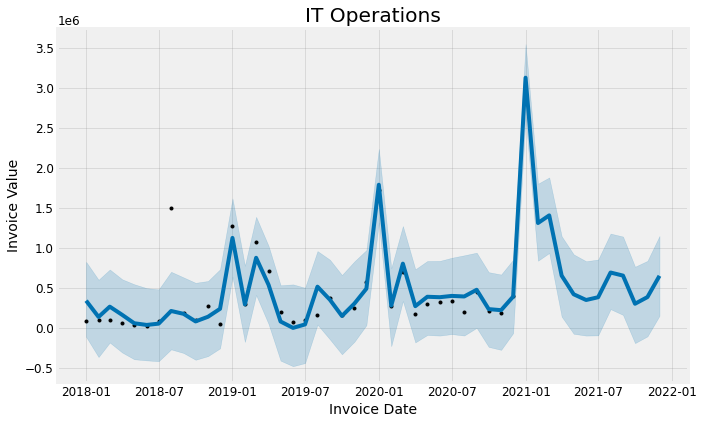

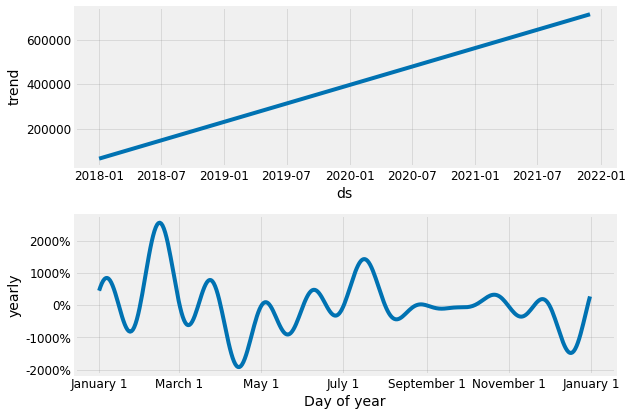

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
36,2021-01-01,563384.796240,2.636093e+06,3.548895e+06,563384.450371,563385.109718,4.554053,4.554053,4.554053,4.554053,4.554053,4.554053,0.0,0.0,0.0,3.129069e+06
37,2021-02-01,577471.420156,8.403333e+05,1.803235e+06,577470.450084,577472.348734,1.271945,1.271945,1.271945,1.271945,1.271945,1.271945,0.0,0.0,0.0,1.311983e+06
38,2021-03-01,590194.822404,9.369931e+05,1.881445e+06,590193.150517,590196.314249,1.384579,1.384579,1.384579,1.384579,1.384579,1.384579,0.0,0.0,0.0,1.407366e+06
39,2021-04-01,604281.446320,1.416315e+05,1.146390e+06,604278.934350,604283.722602,0.082141,0.082141,0.082141,0.082141,0.082141,0.082141,0.0,0.0,0.0,6.539174e+05
40,2021-05-01,617913.663014,-7.317248e+04,9.194058e+05,617910.169277,617916.812116,-0.319161,-0.319161,-0.319161,-0.319161,-0.319161,-0.319161,0.0,0.0,0.0,4.206999e+05
41,2021-06-01,632000.286931,-9.587434e+04,8.338088e+05,631995.915764,632004.584599,-0.447528,-0.447528,-0.447528,-0.447528,-0.447528,-0.447528,0.0,0.0,0.0,3.491627e+05
42,2021-07-01,645632.503624,-9.302895e+04,8.549442e+05,645627.150415,645638.152223,-0.405720,-0.405720,-0.405720,-0.405720,-0.405720,-0.405720,0.0,0.0,0.0,3.836864e+05
43,2021-08-01,659719.127541,2.347520e+05,1.179590e+06,659712.376994,659726.401234,0.050032,0.050032,0.050032,0.050032,0.050032,0.050032,0.0,0.0,0.0,6.927261e+05
44,2021-09-01,673805.751458,1.629742e+05,1.142408e+06,673797.431988,673814.290833,-0.028994,-0.028994,-0.028994,-0.028994,-0.028994,-0.028994,0.0,0.0,0.0,6.542692e+05
45,2021-10-01,687437.968151,-1.901437e+05,7.649796e+05,687428.450590,687447.757491,-0.560495,-0.560495,-0.560495,-0.560495,-0.560495,-0.560495,0.0,0.0,0.0,3.021327e+05


In [25]:
prophet_model(1, area[2], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


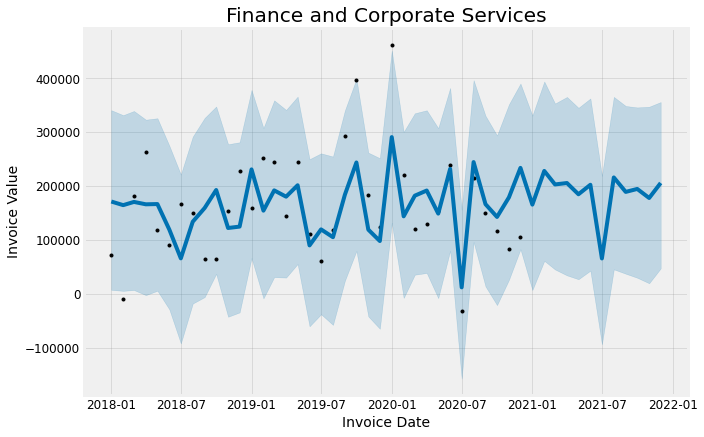

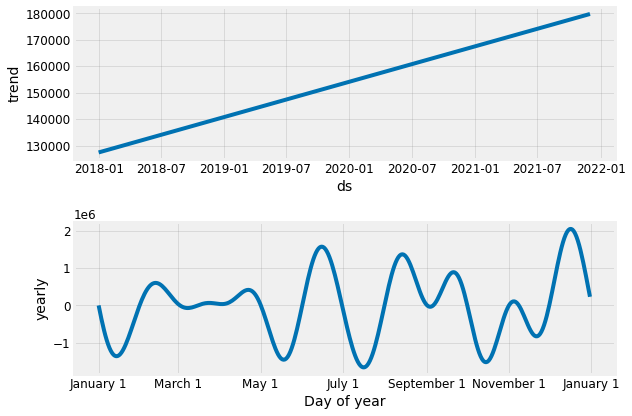

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2021-01-01,167572.908145,7419.935491,330928.050058,167572.858001,167572.969020,-1711.051946,-1711.051946,-1711.051946,-1711.051946,-1711.051946,-1711.051946,0.0,0.0,0.0,165861.856199
37,2021-02-01,168708.465140,61633.412437,394222.764485,168708.302510,168708.633226,59614.714103,59614.714103,59614.714103,59614.714103,59614.714103,59614.714103,0.0,0.0,0.0,228323.179243
38,2021-03-01,169734.129522,45604.811242,353350.903594,169733.853270,169734.414574,33555.103184,33555.103184,33555.103184,33555.103184,33555.103184,33555.103184,0.0,0.0,0.0,203289.232706
39,2021-04-01,170869.686517,34672.315487,365568.133513,170869.269649,170870.130390,35054.040957,35054.040957,35054.040957,35054.040957,35054.040957,35054.040957,0.0,0.0,0.0,205923.727475
40,2021-05-01,171968.612642,27478.159015,345418.200972,171968.035909,171969.252231,13134.893832,13134.893832,13134.893832,13134.893832,13134.893832,13134.893832,0.0,0.0,0.0,185103.506473
41,2021-06-01,173104.169637,43398.786713,362760.155593,173103.399089,173105.022743,29550.682198,29550.682198,29550.682198,29550.682198,29550.682198,29550.682198,0.0,0.0,0.0,202654.851834
42,2021-07-01,174203.095761,-93120.502493,219214.782673,174202.124928,174204.174452,-108170.518624,-108170.518624,-108170.518624,-108170.518624,-108170.518624,-108170.518624,0.0,0.0,0.0,66032.577137
43,2021-08-01,175338.652756,45831.477187,365673.185050,175337.433786,175339.919002,40929.878588,40929.878588,40929.878588,40929.878588,40929.878588,40929.878588,0.0,0.0,0.0,216268.531343
44,2021-09-01,176474.209751,37726.525518,348829.266813,176472.741582,176475.752196,12997.576708,12997.576708,12997.576708,12997.576708,12997.576708,12997.576708,0.0,0.0,0.0,189471.786459
45,2021-10-01,177573.135875,30253.871521,346160.032645,177571.423820,177574.914776,17369.381589,17369.381589,17369.381589,17369.381589,17369.381589,17369.381589,0.0,0.0,0.0,194942.517464


In [44]:
prophet_model_additive(1, area[3], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


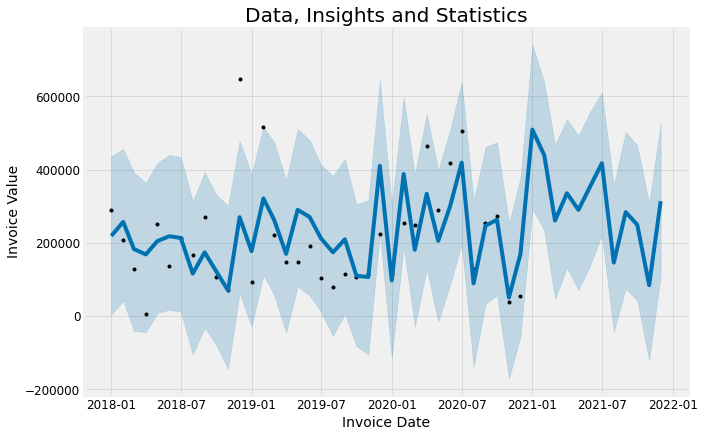

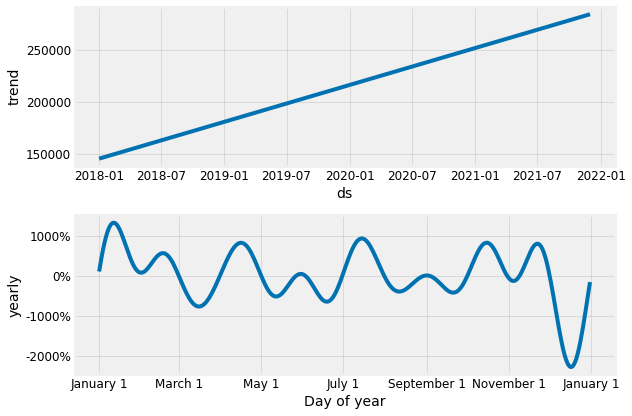

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
36,2021-01-01,251663.717363,293475.005953,741331.824754,251663.717078,251663.717664,1.024850,1.024850,1.024850,1.024850,1.024850,1.024850,0.0,0.0,0.0,509581.195244
37,2021-02-01,254663.945774,233259.123882,638787.409940,254663.944993,254663.946452,0.725276,0.725276,0.725276,0.725276,0.725276,0.725276,0.0,0.0,0.0,439365.472803
38,2021-03-01,257373.829501,46988.602594,467580.234630,257373.828131,257373.830694,0.014806,0.014806,0.014806,0.014806,0.014806,0.014806,0.0,0.0,0.0,261184.468848
39,2021-04-01,260374.057912,132922.437986,538009.816494,260374.055803,260374.059825,0.289762,0.289762,0.289762,0.289762,0.289762,0.289762,0.0,0.0,0.0,335820.539462
40,2021-05-01,263277.504762,71278.608729,493650.180288,263277.501838,263277.507439,0.103702,0.103702,0.103702,0.103702,0.103702,0.103702,0.0,0.0,0.0,290580.011505
41,2021-06-01,266277.733173,140376.060143,559223.094776,266277.729292,266277.736830,0.335285,0.335285,0.335285,0.335285,0.335285,0.335285,0.0,0.0,0.0,355556.694929
42,2021-07-01,269181.180023,220987.511745,610301.102379,269181.175251,269181.184639,0.551753,0.551753,0.551753,0.551753,0.551753,0.551753,0.0,0.0,0.0,417702.635169
43,2021-08-01,272181.408434,-42656.803231,359014.147715,272181.402602,272181.414125,-0.461711,-0.461711,-0.461711,-0.461711,-0.461711,-0.461711,0.0,0.0,0.0,146512.299157
44,2021-09-01,275181.636845,75822.229240,503370.983645,275181.629905,275181.643523,0.032715,0.032715,0.032715,0.032715,0.032715,0.032715,0.0,0.0,0.0,284184.187715
45,2021-10-01,278085.083695,42479.080481,466297.939412,278085.075581,278085.091442,-0.101241,-0.101241,-0.101241,-0.101241,-0.101241,-0.101241,0.0,0.0,0.0,249931.388628


In [45]:
prophet_model_multiplicative(1, area[5], 12)

## Evaluation

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


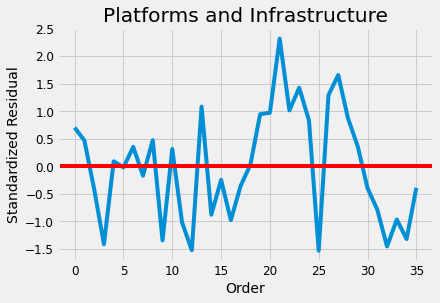

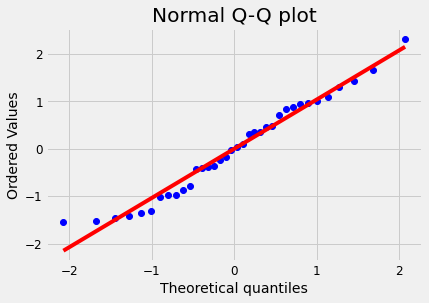

<Figure size 432x288 with 0 Axes>

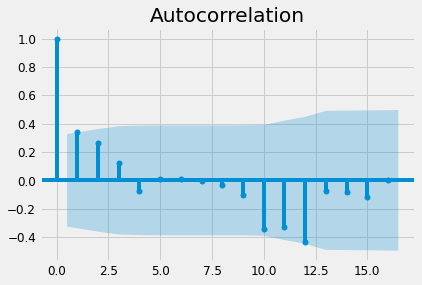

In [46]:
residuals_additive(1, area[0], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


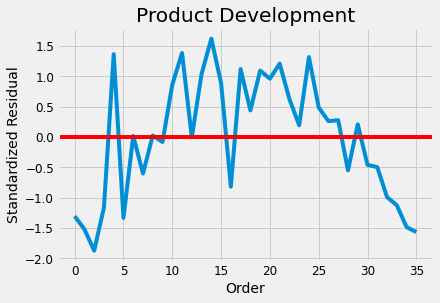

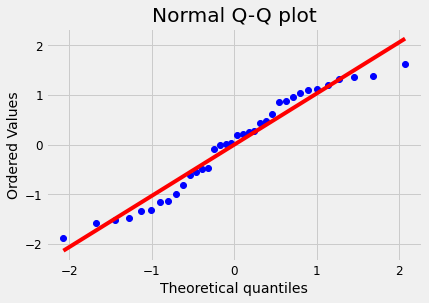

<Figure size 432x288 with 0 Axes>

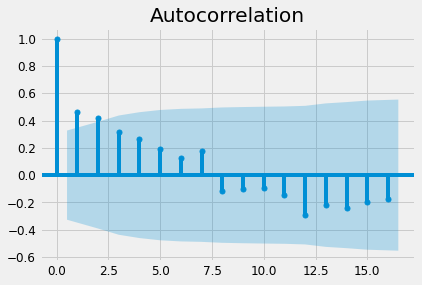

In [50]:
residuals_additive(1, area[1], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


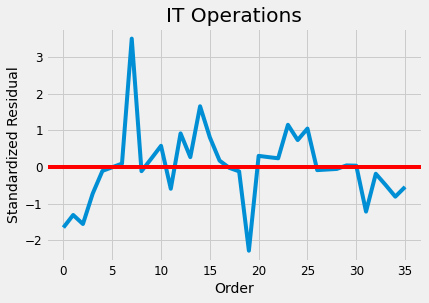

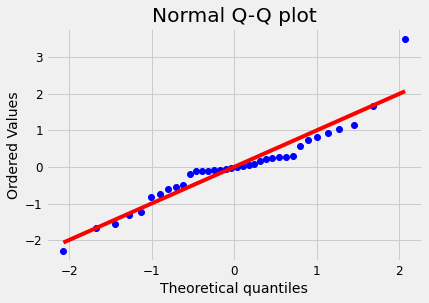

<Figure size 432x288 with 0 Axes>

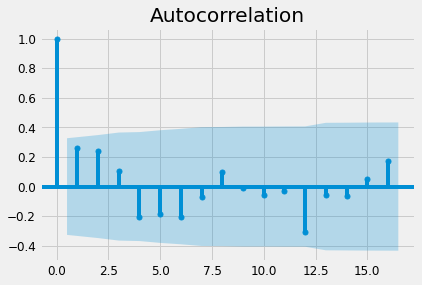

In [47]:
residuals_additive(1, area[2], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


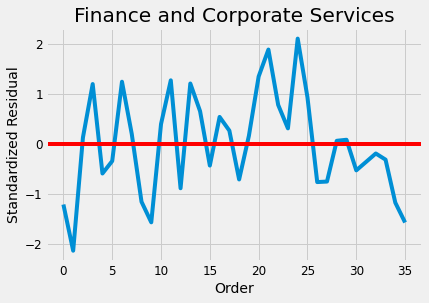

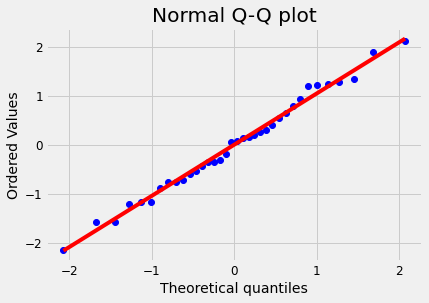

<Figure size 432x288 with 0 Axes>

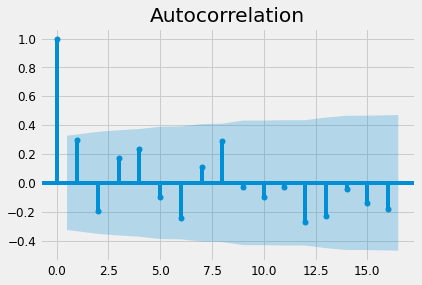

In [48]:
residuals_additive(1, area[3], 12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


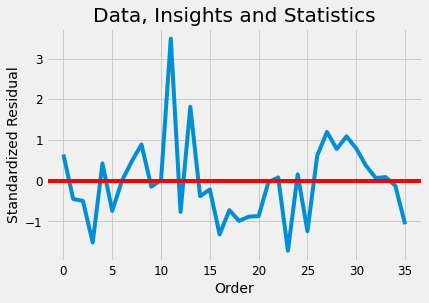

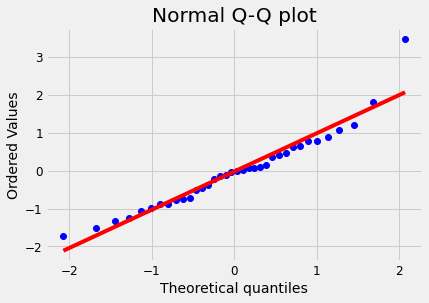

<Figure size 432x288 with 0 Axes>

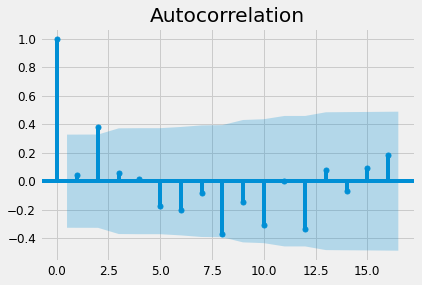

In [49]:
residuals_multiplicative(1, area[5], 12)

In [53]:
def prophet_model_m(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts_all(name, data)['2017':][:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95,  seasonality_mode='multiplicative')
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods, freq='MS')
    forecast = pandi_model.predict(future)
    pandi_model.plot(forecast, uncertainty=True, xlabel = 'Invoice Date', ylabel = 'Invoice Value')
    plt.title(name)
    plt.show()
    pandi_model.plot_components(forecast)
    plt.show()
    f = forecast.tail(periods)
    return f

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


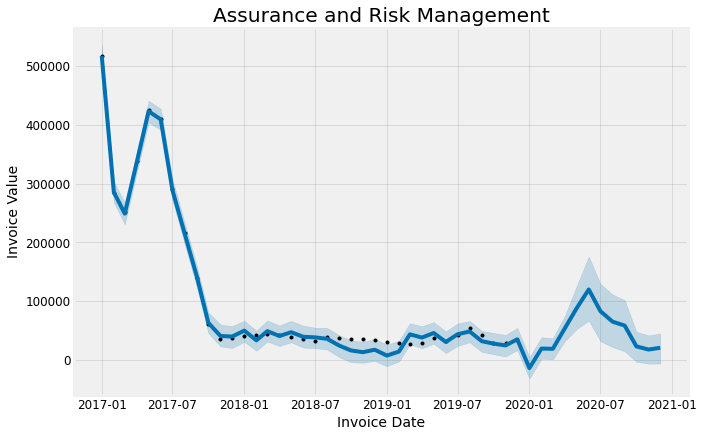

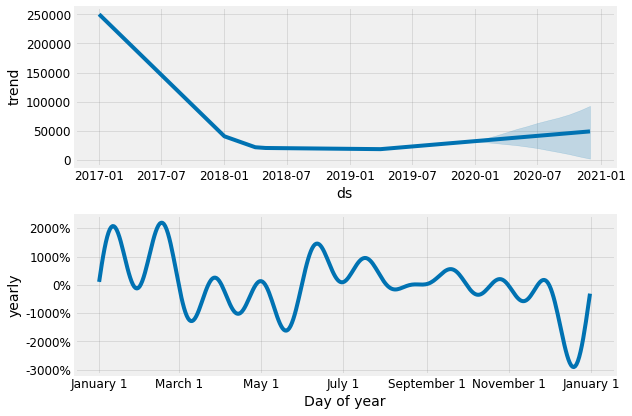

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
36,2020-01-01,32046.853764,-31361.166432,5240.669702,30803.138706,33091.464745,-1.418606,-1.418606,-1.418606,-1.418606,-1.418606,-1.418606,0.0,0.0,0.0,-13415.014190
37,2020-02-01,33596.886788,2526.830976,38775.974815,30220.074833,36941.603218,-0.414535,-0.414535,-0.414535,-0.414535,-0.414535,-0.414535,0.0,0.0,0.0,19669.788151
38,2020-03-01,35046.917681,1258.303809,37203.218680,28620.756184,41599.900187,-0.450221,-0.450221,-0.450221,-0.450221,-0.450221,-0.450221,0.0,0.0,0.0,19268.072268
39,2020-04-01,36596.950705,32624.478851,75557.431111,26806.334410,47275.058692,0.486054,0.486054,0.486054,0.486054,0.486054,0.486054,0.0,0.0,0.0,54385.044887
40,2020-05-01,38096.982663,52739.669359,125728.213567,25062.521895,52962.552226,1.314567,1.314567,1.314567,1.314567,1.314567,1.314567,0.0,0.0,0.0,88178.006457
41,2020-06-01,39647.015687,67175.867951,176066.597659,22651.050821,57911.010038,2.028771,2.028771,2.028771,2.028771,2.028771,2.028771,0.0,0.0,0.0,120081.731512
42,2020-07-01,41147.047646,32169.533263,129348.604054,20097.278978,63294.859906,1.019387,1.019387,1.019387,1.019387,1.019387,1.019387,0.0,0.0,0.0,83091.799395
43,2020-08-01,42697.080669,22207.167309,111626.633845,16596.848735,68044.820106,0.530969,0.530969,0.530969,0.530969,0.530969,0.530969,0.0,0.0,0.0,65367.918680
44,2020-09-01,44247.113693,15139.675456,101851.606479,13244.103993,72635.301878,0.327408,0.327408,0.327408,0.327408,0.327408,0.327408,0.0,0.0,0.0,58733.965840
45,2020-10-01,45747.145651,-2691.571845,48198.062293,9768.569202,77964.974106,-0.489019,-0.489019,-0.489019,-0.489019,-0.489019,-0.489019,0.0,0.0,0.0,23375.908904


In [54]:
prophet_model_m(1, area[6], 12)

In [38]:
def residuals_m(p, name, periods):
    split_time = math.floor(p*len(ts(area[0], data)))
    pandi = ts_all(name, data)['2017':][:split_time]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi_model = Prophet(interval_width=0.95, seasonality_mode='multiplicative')
    pandi_model.fit(pandi)
    future = pandi_model.make_future_dataframe(periods = periods,freq='MS')
    forecast = pandi_model.predict(future)
    df = pd.merge(pandi, forecast, on='ds')
    residuals = df['y'] - df['yhat']
    residuals = pd.Series(residuals)/np.std(residuals)
    f = plt.figure(1)
    residuals.plot(title = name, ylabel = 'Standardized Residual', xlabel = 'Order')
    plt.axhline(y=0, color='r', linestyle='-')
    f.show()
    g = plt.figure(2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    g.show()
    h = plt.figure(3)
    plot_acf(residuals)
    h.show()
    return 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


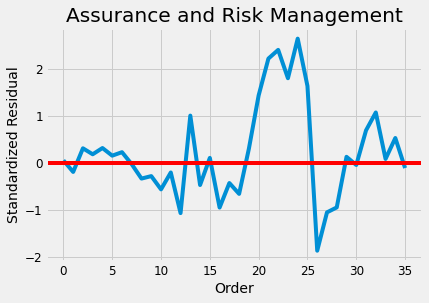

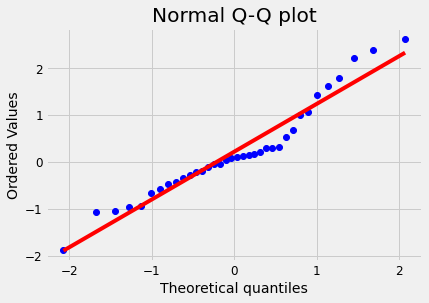

<Figure size 432x288 with 0 Axes>

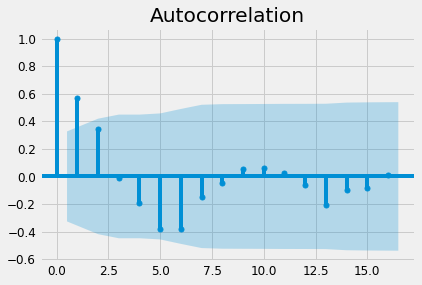

In [39]:
residuals_m(1, area[6], 12)

## Evaluation

In [137]:
def evaluation_additive_model_nrmse(name, periods):
    pandi = ts(name, data)
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi = pandi.drop(pandi.index[-periods:]) #training
    model = Prophet(seasonality_mode = 'additive')
    model.fit(pandi)
    future = model.make_future_dataframe(periods = periods, freq='MS')
    forecast = model.predict(future)
    y_true = pandi['y'][-periods:].values
    y_pred = forecast['yhat'][-periods:].values
    mse = mean_squared_error(y_true, y_pred)
    nrmse = np.sqrt(mse)/np.mean(y_true)
    return nrmse

In [138]:
def evaluation_multi_model_nrmse(name, periods):
    pandi = ts(name, data)
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi = pandi.drop(pandi.index[-periods:]) #training
    model = Prophet(seasonality_mode = 'multiplicative')
    model.fit(pandi)
    future = model.make_future_dataframe(periods = periods, freq='MS')
    forecast = model.predict(future)
    y_true = pandi['y'][-periods:].values
    y_pred = forecast['yhat'][-periods:].values
    mse = mean_squared_error(y_true, y_pred)
    nrmse = np.sqrt(mse)/np.mean(y_true)
    return nrmse

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

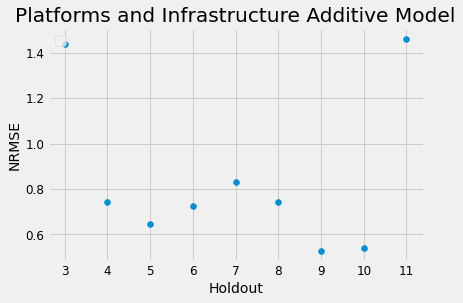

,Out-of-sample size,NRMSE
0,3,1.439744
1,4,0.741695
2,5,0.646099
3,6,0.724280
4,7,0.828537
5,8,0.743135
6,9,0.527904
7,10,0.540048
8,11,1.462674


In [221]:
result = [evaluation_additive_model_nrmse(area[0], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[0] + ' Additive Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

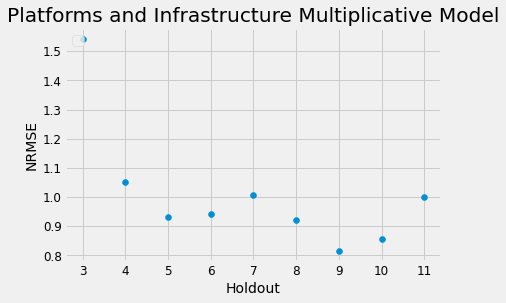

,Out-of-sample size,NRMSE
0,3,1.543135
1,4,1.053297
2,5,0.930893
3,6,0.940995
4,7,1.008678
5,8,0.922028
6,9,0.816359
7,10,0.857065
8,11,0.999991


In [224]:
result = [evaluation_multi_model_nrmse(area[0], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[0] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

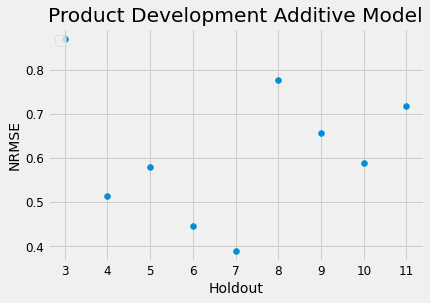

,Out-of-sample size,NRMSE
0,3,0.870967
1,4,0.514328
2,5,0.579750
3,6,0.446052
4,7,0.390319
5,8,0.776974
6,9,0.658065
7,10,0.590185
8,11,0.717547


In [223]:
result = [evaluation_additive_model_nrmse(area[1], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[1] + ' Additive Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

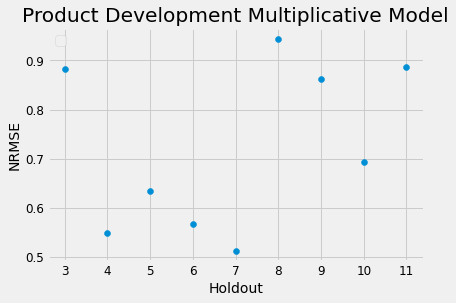

,Out-of-sample size,NRMSE
0,3,0.881735
1,4,0.548510
2,5,0.633421
3,6,0.566298
4,7,0.512738
5,8,0.944505
6,9,0.862799
7,10,0.692381
8,11,0.886803


In [225]:
result = [evaluation_multi_model_nrmse(area[1], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[1] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

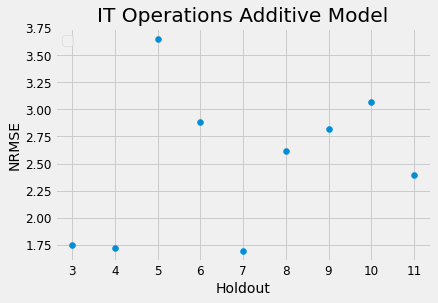

,Out-of-sample size,NRMSE
0,3,1.747442
1,4,1.720390
2,5,3.654303
3,6,2.886176
4,7,1.694827
5,8,2.619790
6,9,2.815901
7,10,3.068188
8,11,2.391617


In [226]:
result = [evaluation_additive_model_nrmse(area[2], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[2] + ' Additive Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

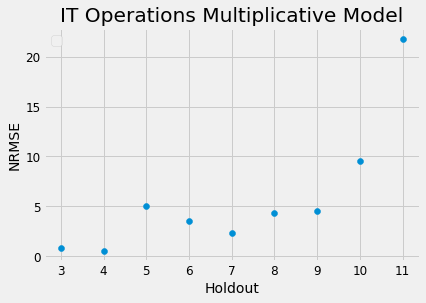

,Out-of-sample size,NRMSE
0,3,0.791763
1,4,0.568589
2,5,5.017789
3,6,3.563939
4,7,2.355370
5,8,4.315143
6,9,4.564363
7,10,9.567782
8,11,21.797670


In [227]:
result = [evaluation_multi_model_nrmse(area[2], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[2] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

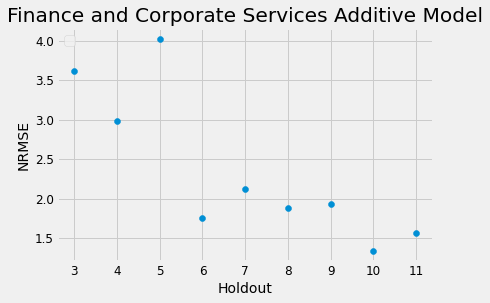

,Out-of-sample size,NRMSE
0,3,3.610738
1,4,2.976907
2,5,4.024562
3,6,1.753282
4,7,2.128233
5,8,1.876429
6,9,1.932144
7,10,1.342089
8,11,1.568883


In [228]:
result = [evaluation_additive_model_nrmse(area[3], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[3] + ' Additive Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

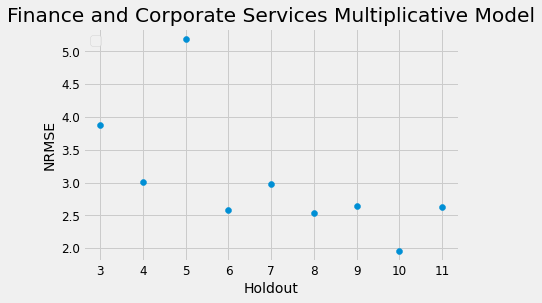

,Out-of-sample size,NRMSE
0,3,3.884674
1,4,3.004793
2,5,5.195138
3,6,2.575696
4,7,2.983305
5,8,2.532792
6,9,2.644987
7,10,1.962235
8,11,2.630805


In [229]:
result = [evaluation_multi_model_nrmse(area[3], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[3] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

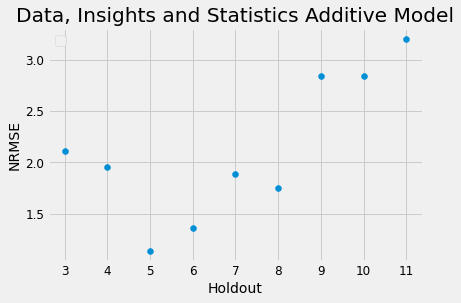

,Out-of-sample size,NRMSE
0,3,2.111109
1,4,1.957774
2,5,1.137728
3,6,1.363963
4,7,1.891519
5,8,1.754965
6,9,2.844888
7,10,2.845432
8,11,3.210119


In [230]:
result = [evaluation_additive_model_nrmse(area[5], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[5] + ' Additive Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_chang

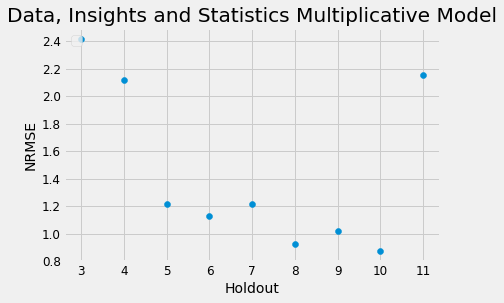

,Out-of-sample size,NRMSE
0,3,2.418897
1,4,2.121598
2,5,1.216857
3,6,1.126778
4,7,1.219704
5,8,0.924366
6,9,1.020203
7,10,0.876728
8,11,2.156639


In [231]:
result = [evaluation_multi_model_nrmse(area[5], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[5] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

In [164]:
def evaluation_additive_model_nrmse_m(name, periods):
    pandi = ts_all(name, data)['2017':]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi = pandi.drop(pandi.index[-periods:]) #training
    model = Prophet(seasonality_mode = 'additive')
    model.fit(pandi)
    future = model.make_future_dataframe(periods = periods, freq='MS')
    forecast = model.predict(future)
    y_true = pandi['y'][-periods:].values
    y_pred = forecast['yhat'][-periods:].values
    mse = mean_squared_error(y_true, y_pred)
    nrmse = np.sqrt(mse)/np.mean(y_true)
    return nrmse

In [165]:
def evaluation_multi_model_nrmse_m(name, periods):
    pandi = ts_all(name, data)['2017':]
    pandi = pandi.to_frame().reset_index().rename(columns = {'Invoice Date':'ds', 'Invoice Value':'y'})
    pandi = pandi.drop(pandi.index[-periods:]) #training
    model = Prophet(seasonality_mode = 'multiplicative')
    model.fit(pandi)
    future = model.make_future_dataframe(periods = periods, freq='MS')
    forecast = model.predict(future)
    y_true = pandi['y'][-periods:].values
    y_pred = forecast['yhat'][-periods:].values
    mse = mean_squared_error(y_true, y_pred)
    nrmse = np.sqrt(mse)/np.mean(y_true)
    return nrmse

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

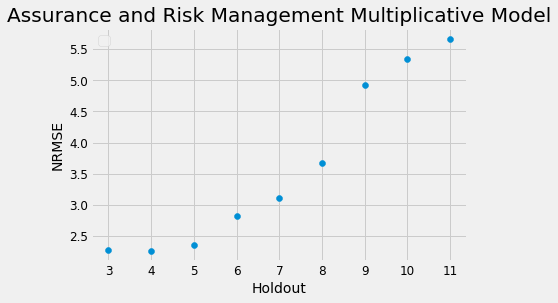

,Out-of-sample size,NRMSE
0,3,2.275631
1,4,2.264339
2,5,2.354187
3,6,2.816549
4,7,3.103380
5,8,3.672912
6,9,4.929955
7,10,5.339830
8,11,5.670297


In [236]:
result = [evaluation_additive_model_nrmse_m(area[6], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[6] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

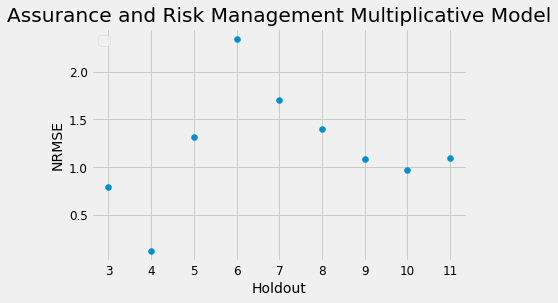

,Out-of-sample size,NRMSE
0,3,0.795807
1,4,0.130223
2,5,1.315989
3,6,2.344118
4,7,1.701514
5,8,1.397923
6,9,1.084566
7,10,0.975220
8,11,1.095222


In [237]:
result = [evaluation_multi_model_nrmse_m(area[6], x) for x in range(3, 12)]
plt.scatter(np.arange(3,12), np.asarray(result))
plt.xlabel("Holdout")
plt.ylabel("NRMSE")
plt.legend(loc='upper left')
plt.title(area[6] + ' Multiplicative Model')
plt.show()
pd.DataFrame({'Out-of-sample size':np.arange(3,12), 'NRMSE':np.asarray(result)})